In [1]:
import numpy as np
import pandas as pd
import os
import sklearn as sk
import torch
from torch_sparse import SparseTensor
from scipy import sparse
import matplotlib.pyplot as plt

from GNNfuncs import *

In [ ]:
cwd = '..'
artists = pd.read_csv(os.path.join(cwd,'data','artists.dat'), delimiter='\t')
tags = pd.read_csv(os.path.join(cwd,'data','tags.dat'), delimiter='\t',encoding='ISO-8859-1')
user_artists = pd.read_csv(os.path.join(cwd,'data','user_artists.dat'), delimiter='\t')
user_friends = pd.read_csv(os.path.join(cwd,'data','user_friends.dat'), delimiter='\t')
user_taggedartists_timestamps = pd.read_csv(os.path.join(cwd,'data','user_taggedartists-timestamps.dat'), delimiter='\t')
user_taggedartists = pd.read_csv(os.path.join(cwd,'data','user_taggedartists.dat'), delimiter='\t')

In [ ]:
users = user_artists['userID'].unique()
singleartistusers = [user for user in users if len(get_artists(user,user_artists)) == 1]
singleartistusersdf = user_artists[user_artists['userID'].isin(singleartistusers)]
user_artists_temp = user_artists[~user_artists['userID'].isin(singleartistusers)]

In [ ]:
from sklearn.model_selection import train_test_split

user_artists_train, user_artists_test = train_test_split(user_artists_temp, test_size = 0.2, stratify = user_artists_temp['userID'], random_state = 47)

user_artists_train = pd.concat([user_artists_train,singleartistusersdf])

In [ ]:
user_taggedartists_test = user_taggedartists.merge(user_artists_test[['userID','artistID']], on = ['userID','artistID'], how = 'inner')
user_taggedartists_train = user_taggedartists.merge(user_artists_test[['userID','artistID']], on = ['userID','artistID'], how = 'left', indicator = True)
user_taggedartists_train = user_taggedartists_train[user_taggedartists_train['_merge'] == 'left_only'].drop(columns = ['_merge'])

In [ ]:
dfs = [user_artists_train,user_artists_test,user_friends]

filepath = os.path.join(cwd,'data','GNN')
if not os.path.exists(filepath):
    os.makedirs(filepath)

for df in dfs:
    df.to_csv(os.path.join(filepath,get_df_name(df, globals()) + '.txt'),sep='\t',header=False,index=False)

## LightGCN

Defining the dataset

already has lastfm dataset defined but it is slightly different to ours, so we will add ours to dataloader.py. This consists of adding it as a class to dataloader.py, done by duplicating and editing the already existing LastFM class. We then add an elif statement to register.py to register it, and finally add it to the `all_dataset` list in world.py.

In [ ]:
print(users)
artistlist = list(artists['id'].unique())
print(artistlist)

In [ ]:
code_to_write = '''
class LastFM2(BasicDataset):
    """
    Dataset type for pytorch
    LastFM dataset 2
    """
    def __init__(self, path="../data/GNN"):
        # train or test
        cprint("loading [last fm 2]")
        self.mode_dict = {'train':0, "test":1}
        self.mode    = self.mode_dict['train']
        # self.n_users = 2100
        # self.m_items = 18745
        trainData = pd.read_table(join(path, 'user_artists_train.txt'), header=None)
        print(trainData.head())
        testData  = pd.read_table(join(path, 'user_artists_test.txt'), header=None)
        print(testData.head())
        trustNet  = pd.read_table(join(path, 'user_friends.txt'), header=None).to_numpy()
        print(trustNet[:5])
        trustNet -= 1
        trainData-= 1
        testData -= 1
        self.trustNet  = trustNet
        self.trainData = trainData
        self.testData  = testData
        self.trainUser = np.array(trainData[:][0])
        self.trainUniqueUsers = np.unique(self.trainUser)
        self.trainItem = np.array(trainData[:][1])
        # self.trainDataSize = len(self.trainUser)
        self.testUser  = np.array(testData[:][0])
        self.testUniqueUsers = np.unique(self.testUser)
        self.testItem  = np.array(testData[:][1])
        self.Graph = None
        print(f"LastFm2 Sparsity : {(len(self.trainUser) + len(self.testUser))/self.n_users/self.m_items}")
        
        # (users,users)
        self.socialNet    = csr_matrix((np.ones(len(trustNet)), (trustNet[:,0], trustNet[:,1]) ), shape=(self.n_users,self.n_users))
        # (users,items), bipartite graph
        self.UserItemNet  = csr_matrix((np.ones(len(self.trainUser)), (self.trainUser, self.trainItem) ), shape=(self.n_users,self.m_items)) 
        
        # pre-calculate
        self._allPos = self.getUserPosItems(list(range(self.n_users)))
        self.allNeg = []
        allItems    = set(range(self.m_items))
        for i in range(self.n_users):
            pos = set(self._allPos[i])
            neg = allItems - pos
            self.allNeg.append(np.array(list(neg)))
        self.__testDict = self.__build_test()

    @property
    def n_users(self):
        return 2100
    
    @property
    def m_items(self):
        return 18745
    
    @property
    def trainDataSize(self):
        return len(self.trainUser)
    
    @property
    def testDict(self):
        return self.__testDict

    @property
    def allPos(self):
        return self._allPos

    def getSparseGraph(self):
        if self.Graph is None:
            user_dim = torch.LongTensor(self.trainUser)
            item_dim = torch.LongTensor(self.trainItem)
            
            first_sub = torch.stack([user_dim, item_dim + self.n_users])
            second_sub = torch.stack([item_dim+self.n_users, user_dim])
            index = torch.cat([first_sub, second_sub], dim=1)
            data = torch.ones(index.size(-1)).int()
            self.Graph = torch.sparse.IntTensor(index, data, torch.Size([self.n_users+self.m_items, self.n_users+self.m_items]))
            dense = self.Graph.to_dense()
            D = torch.sum(dense, dim=1).float()
            D[D==0.] = 1.
            D_sqrt = torch.sqrt(D).unsqueeze(dim=0)
            dense = dense/D_sqrt
            dense = dense/D_sqrt.t()
            index = dense.nonzero()
            data  = dense[dense >= 1e-9]
            assert len(index) == len(data)
            self.Graph = torch.sparse.FloatTensor(index.t(), data, torch.Size([self.n_users+self.m_items, self.n_users+self.m_items]))
            self.Graph = self.Graph.coalesce().to(world.device)
        return self.Graph

    def __build_test(self):
        """
        return:
            dict: {user: [items]}
        """
        test_data = {}
        for i, item in enumerate(self.testItem):
            user = self.testUser[i]
            if test_data.get(user):
                test_data[user].append(item)
            else:
                test_data[user] = [item]
        return test_data
    
    def getUserItemFeedback(self, users, items):
        """
        users:
            shape [-1]
        items:
            shape [-1]
        return:
            feedback [-1]
        """
        # print(self.UserItemNet[users, items])
        return np.array(self.UserItemNet[users, items]).astype('uint8').reshape((-1, ))
    
    def getUserPosItems(self, users):
        posItems = []
        for user in users:
            posItems.append(self.UserItemNet[user].nonzero()[1])
        return posItems
    
    def getUserNegItems(self, users):
        negItems = []
        for user in users:
            negItems.append(self.allNeg[user])
        return negItems
            
    
    
    def __getitem__(self, index):
        user = self.trainUniqueUsers[index]
        # return user_id and the positive items of the user
        return user
    
    def switch2test(self):
        """
        change dataset mode to offer test data to dataloader
        """
        self.mode = self.mode_dict['test']
    
    def __len__(self):
        return len(self.trainUniqueUsers)
'''

In [ ]:
dataloaderpath = os.path.join('..','scripts','LightGCN','dataloader.py')
dataloader = open(dataloaderpath)

if 'class LastFM2(BasicDataset)' not in dataloader.read():
    with open(dataloaderpath,'a') as file:
        file.write(code_to_write)
        print('Class added.')
else:
    print('Class already present.')

In [14]:
resultspath = os.path.join('..','scripts','LightGCN','results')
if not os.path.exists(resultspath):
    os.makedirs(resultspath)
resultsfile = os.path.join(resultspath,'results.csv')
if os.path.exists(resultsfile):
    os.remove(resultsfile)
pd.DataFrame(columns=['precision','recall','ndcg']).to_csv(resultsfile)

In [1]:
%run -i ../scripts/LightGCN/main.py --decay=1e-4 --lr=0.001 --layer=3 --seed=47 --dataset="lastfm2" --topks="[20]" --recdim=64 --epochs=10 --device=CPU

Device used is cpu, with multicore: 0.
Cpp extension not loaded
>>SEED: 47
loading [last fm]
      0     1     2
0   443   174   786
1  1197   325   744
2   826  2009    18
3  1186   302   810
4   586  4271  3625
      0      1     2
0  1639    176  1814
1  1904    609   132
2  1358  14094   378
3  1086  12208  2658
4  1559    300   107
[[  2 275]
 [  2 428]
 [  2 515]
 [  2 761]
 [  2 831]]
LastFm2 Sparsity : 0.00235706955576828
===========config================
{'A_n_fold': 100,
 'A_split': False,
 'bigdata': False,
 'bpr_batch_size': 2048,
 'decay': 0.0001,
 'dropout': 0,
 'keep_prob': 0.6,
 'latent_dim_rec': 64,
 'lightGCN_n_layers': 3,
 'lr': 0.001,
 'multicore': 0,
 'pretrain': 0,
 'test_u_batch_size': 100}
cores for test: 8
comment: lgn
tensorboard: 1
LOAD: 0
Weight path: ./checkpoints
Test Topks: [20]
using bpr loss
===========end===================
Device used is cpu, with multicore: 0.
Cpp extension not loaded
loading [last fm]
      0     1     2
0   443   174   786
1  1197 

C:\Users\Sheri\Documents\GitHub\dst-assessment-2\scripts\LightGCN\dataloader.py:487: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:653.)
  self.Graph = torch.sparse.IntTensor(index, data, torch.Size([self.n_users+self.m_items, self.n_users+self.m_items]))


lgn is already to go(dropout:0)
load and save to C:\Users\Sheri\Documents\GitHub\dst-assessment-2\scripts\code\checkpoints\lgn-lastfm2-3-64.pth.tar
[TEST]
{'precision': array([0.00026567]), 'recall': array([0.00053135]), 'ndcg': array([0.00040668])}
EPOCH[1/10] loss0.686-|Sample:0.79|
EPOCH[2/10] loss0.660-|Sample:0.68|
EPOCH[3/10] loss0.571-|Sample:0.79|
EPOCH[4/10] loss0.446-|Sample:0.68|
EPOCH[5/10] loss0.350-|Sample:0.78|
EPOCH[6/10] loss0.296-|Sample:0.67|
EPOCH[7/10] loss0.265-|Sample:0.78|
EPOCH[8/10] loss0.241-|Sample:0.78|
EPOCH[9/10] loss0.224-|Sample:0.68|
EPOCH[10/10] loss0.211-|Sample:0.79|
[TEST]
{'precision': array([0.0642933]), 'recall': array([0.13117884]), 'ndcg': array([0.13391279])}
EPOCH[11/10] loss0.199-|Sample:0.66|
Total time taken: 79.41200017929077


In [ ]:
%run -i "../scripts/LightGCN/main.py" --decay=1e-4 --lr=0.001 --layer=3 --seed=47 --dataset="lastfm2" --topks="[20]" --recdim=64 --epochs=10 --device=GPU 

Device used is cuda, with multicore: 0.
Cpp extension not loaded
>>SEED: 47
loading [last fm]
      0     1     2
0   443   174   786
1  1197   325   744
2   826  2009    18
3  1186   302   810
4   586  4271  3625
      0      1     2
0  1639    176  1814
1  1904    609   132
2  1358  14094   378
3  1086  12208  2658
4  1559    300   107
[[  2 275]
 [  2 428]
 [  2 515]
 [  2 761]
 [  2 831]]
LastFm2 Sparsity : 0.002358317773628523
===========config================
{'A_n_fold': 100,
 'A_split': False,
 'bigdata': False,
 'bpr_batch_size': 2048,
 'decay': 0.0001,
 'dropout': 0,
 'keep_prob': 0.6,
 'latent_dim_rec': 64,
 'lightGCN_n_layers': 3,
 'lr': 0.001,
 'multicore': 0,
 'pretrain': 0,
 'test_u_batch_size': 100}
cores for test: 4
comment: lgn
tensorboard: 1
LOAD: 0
Weight path: ./checkpoints
Test Topks: [20]
using bpr loss
===========end===================
Device used is cuda, with multicore: 0.
Cpp extension not loaded
loading [last fm]
      0     1     2
0   443   174   786
1  11

C:\Users\Sheri\Documents\GitHub\dst-assessment-2\scripts\LightGCN\dataloader.py:487: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:653.)
  self.Graph = torch.sparse.IntTensor(index, data, torch.Size([self.n_users+self.m_items, self.n_users+self.m_items]))


lgn is already to go(dropout:0)
load and save to C:\Users\Sheri\Documents\GitHub\dst-assessment-2\scripts\code\checkpoints\lgn-lastfm2-3-64.pth.tar
[TEST]
{'precision': array([0.00061105]), 'recall': array([0.00122801]), 'ndcg': array([0.00092211])}
EPOCH[1/10] loss0.686-|Sample:0.67|
EPOCH[2/10] loss0.661-|Sample:0.78|
EPOCH[3/10] loss0.575-|Sample:0.77|
EPOCH[4/10] loss0.451-|Sample:0.66|
EPOCH[5/10] loss0.354-|Sample:0.77|
EPOCH[6/10] loss0.298-|Sample:0.77|
EPOCH[7/10] loss0.267-|Sample:0.65|
EPOCH[8/10] loss0.243-|Sample:0.78|
EPOCH[9/10] loss0.225-|Sample:0.66|
EPOCH[10/10] loss0.211-|Sample:0.76|
[TEST]
{'precision': array([0.06259299]), 'recall': array([0.12805568]), 'ndcg': array([0.12743833])}
EPOCH[11/10] loss0.200-|Sample:0.77|
Total time taken: 16.980195999145508


In [4]:
from IPython import get_ipython

for ks in [5,10,15,20,25,30]:
    get_ipython().run_line_magic('run', f'-i ../scripts/LightGCN/main.py --decay=1e-4 --lr=0.001 --layer=3 --seed=47 --dataset="lastfm2" --topks="[{ks}]" --recdim=64 --epochs=100 --device=GPU')

# %run -i "../scripts/LightGCN/main.py" --decay=1e-4 --lr=0.001 --layer=3 --seed=47 --dataset="lastfm2" --topks="[25]" --recdim=64 --epochs=100 --device=GPU

>>SEED: 47
Device used is cuda.
Cpp extension not loaded
loading [last fm]
      0     1     2
0   443   174   786
1  1197   325   744
2   826  2009    18
3  1186   302   810
4   586  4271  3625
      0      1     2
0  1639    176  1814
1  1904    609   132
2  1358  14094   378
3  1086  12208  2658
4  1559    300   107
[[  2 275]
 [  2 428]
 [  2 515]
 [  2 761]
 [  2 831]]
LastFm2 Sparsity : 0.002358317773628523
===========config================
{'A_n_fold': 100,
 'A_split': False,
 'bigdata': False,
 'bpr_batch_size': 2048,
 'decay': 0.0001,
 'dropout': 0,
 'keep_prob': 0.6,
 'latent_dim_rec': 64,
 'lightGCN_n_layers': 3,
 'lr': 0.001,
 'multicore': 0,
 'pretrain': 0,
 'test_u_batch_size': 100}
cores for test: 8
comment: lgn
tensorboard: 1
LOAD: 0
Weight path: ./checkpoints
Test Topks: [5]
using bpr loss
===========end===================
use NORMAL distribution initilizer
lgn is already to go(dropout:0)
load and save to C:\Users\Sheri\Documents\GitHub\dst-assessment-2\scripts\code\ch

In [ ]:
from model import LightGCN
from register import dataset

Recmodel = register.MODELS[world.model_name](world.config, dataset).to(world.device)
checkpoint = torch.load('../scripts/code/checkpoints/lgn-lastfm2-3-64.pth.tar')
Recmodel.load_state_dict(checkpoint)

In [ ]:
user_id = 2
user_tensor = torch.tensor([user_id]).to(world.device)
user_artist_test_list = get_artists(user_id, user_artists_test)

for artist_id in user_artist_test_list:
    artist_tensor = torch.tensor([artist_id]).to(world.device)
    recommendation_score = Recmodel(user_tensor,artist_tensor)
    print(f'For user {user_id}, artist {artist_id} is recommended with score {recommendation_score.item()}')

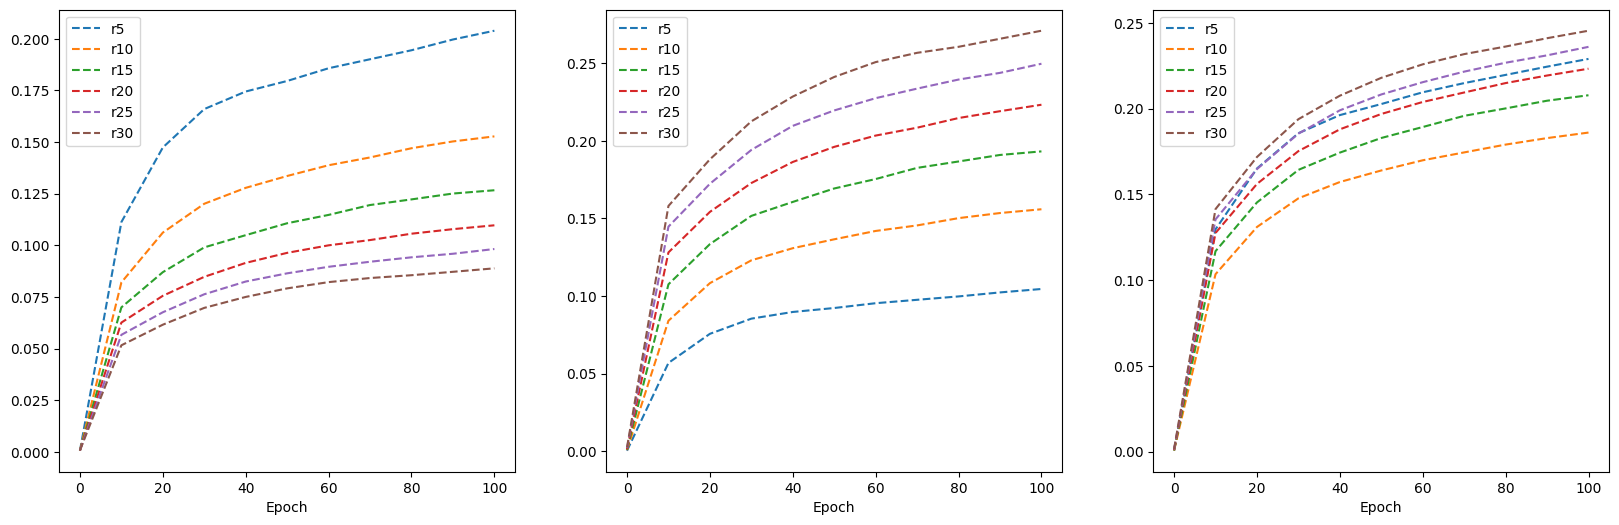

In [11]:
results = pd.read_csv(os.path.join('..','scripts','LightGCN','results','results.csv'),index_col='Unnamed: 0')
r5 = results[:11]
r10 = results[11:22]
r15 = results[22:33]
r20 = results[33:44]
r25 = results[44:55]
r30 = results[55:]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

for df in [r5, r10, r15, r20, r25, r30]:
    ax1.plot(df.index, df['precision'], '--', label=get_df_name(df, globals()))
    ax2.plot(df.index, df['recall'], '--', label=get_df_name(df, globals()))
    ax3.plot(df.index, df['ndcg'], '--', label=get_df_name(df, globals()))

ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax3.set_xlabel('Epoch')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

In [15]:
from IPython import get_ipython

for layers in [1,2,3]:
    get_ipython().run_line_magic('run', f'-i ../scripts/LightGCN/main.py --decay=1e-4 --lr=0.001 --layer={layers} --seed=47 --dataset="lastfm2" --topks="[20]" --recdim=64 --epochs=250 --device=GPU')

>>SEED: 47
Device used is cuda.
Cpp extension not loaded
loading [last fm]
      0     1     2
0   443   174   786
1  1197   325   744
2   826  2009    18
3  1186   302   810
4   586  4271  3625
      0      1     2
0  1639    176  1814
1  1904    609   132
2  1358  14094   378
3  1086  12208  2658
4  1559    300   107
[[  2 275]
 [  2 428]
 [  2 515]
 [  2 761]
 [  2 831]]
LastFm2 Sparsity : 0.002358317773628523
===========config================
{'A_n_fold': 100,
 'A_split': False,
 'bigdata': False,
 'bpr_batch_size': 2048,
 'decay': 0.0001,
 'dropout': 0,
 'keep_prob': 0.6,
 'latent_dim_rec': 64,
 'lightGCN_n_layers': 1,
 'lr': 0.001,
 'multicore': 0,
 'pretrain': 0,
 'test_u_batch_size': 100}
cores for test: 8
comment: lgn
tensorboard: 1
LOAD: 0
Weight path: ./checkpoints
Test Topks: [20]
using bpr loss
===========end===================
use NORMAL distribution initilizer
lgn is already to go(dropout:0)
load and save to C:\Users\Sheri\Documents\GitHub\dst-assessment-2\scripts\code\c

In [6]:
def get_df_name(df : pd.DataFrame, globals : dict): # From https://stackoverflow.com/questions/31727333/get-the-name-of-a-pandas-dataframe
    """Returns the name of the input dataframe as a string. Solely used for nice formatting. Requires input of globals() dict."""
    name =[x for x in globals if globals[x] is df][0]
    return name


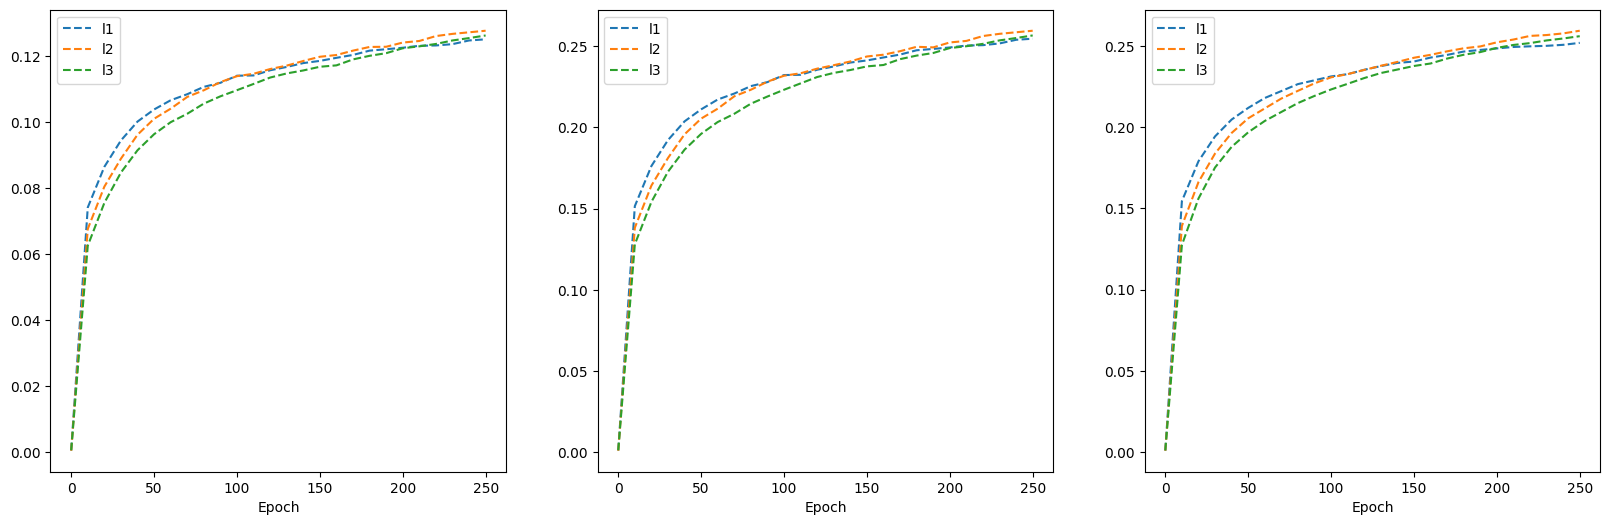

In [7]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
cwd = os.getcwd()

results = pd.read_csv(os.path.join(cwd,'scripts','LightGCN','results','results.csv'),index_col='Unnamed: 0')
l1 = results[:26]
l2 = results[26:52]
l3 = results[52:]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

for df in [l1,l2,l3]:
    ax1.plot(df.index, df['precision'], '--', label=get_df_name(df, globals()))
    ax2.plot(df.index, df['recall'], '--', label=get_df_name(df, globals()))
    ax3.plot(df.index, df['ndcg'], '--', label=get_df_name(df, globals()))

ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax3.set_xlabel('Epoch')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()